In [1]:
%matplotlib inline
import pandas as pd
import pprint
import subprocess
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy.stats as stats
from matplotlib import colors
from matplotlib.colors import ListedColormap
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LassoCV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.preprocessing import FunctionTransformer, scale
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_predict
from sklearn.pipeline import make_pipeline


In [2]:
sns.set(rc={'figure.figsize':(15,8)})  # Change all graphs backgrounds

In [3]:
white_wine_csv = "dataset/winequality-white.csv"

# Load The Data

We will be using pandas to load the data into a dataframe. On first inspection of the data, it was noticed that the csv file was using a different seperator than what one would normally see and when loading in the data from the csv file it was all coming out in one column. To get around this it was necessary to update the `sep` value to use `;` when using the `read_csv` function. 

The data is split into multiple columns. The dataset, which can be found here -  https://archive.ics.uci.edu/ml/datasets/wine+quality outlines the following features.

* 1 - fixed acidity 
* 2 - volatile acidity 
* 3 - citric acid 
* 4 - residual sugar 
* 5 - chlorides 
* 6 - free sulfur dioxide 
* 7 - total sulfur dioxide 
* 8 - density 
* 9 - pH 
* 10 - sulphates 
* 11 - alcohol 
* 12 - Output variable (based on sensory data): quality (score between 0 and 10)

In [4]:
df = pd.read_csv(white_wine_csv, header=None, sep=';', skiprows=1, names = ["fixed_acidity", "volatile_acidity", "citric_acid", "residual_sugar", "chlorides", "free_sulfur_dioxide", "total_sulfur_dioxide", "density", "pH", "sulphates", "alcohol", "quality"])

# Missing Data

Lets first scope out the data in the dataset to make sure there are no anomilies.

In [5]:
df.shape

(4898, 12)

Using the handy `shape` attribute of our dataframe we can quickly see that we are dealing with `4898` rows and `12` columns or features.

In [6]:
df.dtypes

fixed_acidity           float64
volatile_acidity        float64
citric_acid             float64
residual_sugar          float64
chlorides               float64
free_sulfur_dioxide     float64
total_sulfur_dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
quality                   int64
dtype: object

The `dtypes` attribute of the dataframe gives a quick summary of the data type of each column. The first 11 features have a data type of `float64` which is correct as we are dealing with decimal values. The 12th column is an `int64` data type. This is also correct as this value ranges from 0 - 10. The closer to 10 the higher the quality of wine. Based on the above output it looks like pandas is inferring the correct data types for each column

In [7]:
nans_predicate = df.isnull().any(axis=1)
nans = df[nans_predicate]
nans

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality


As all our data should be numeric and non null we can quickly check for the presence of non numeric or null data using the `nans_predicate` above. Luckily there are no null, or non numeric values detected which is good.

# Erroneous Data

Lets now do an analysis to see if we can find any erroneous data. What I will try to do in this section is determine if the data is reasonable from a logical sense.

In [8]:
df.describe()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
count,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000
mean,6.854788,0.278241,0.334192,6.391415,0.045772,35.308085,138.360657,0.994027,3.188267,0.489847,10.514267,5.877909
std,0.843868,0.100795,0.121020,5.072058,0.021848,17.007137,42.498065,0.002991,0.151001,0.114126,1.230621,0.885639
min,3.800000,0.080000,0.000000,0.600000,0.009000,2.000000,9.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.300000,0.210000,0.270000,1.700000,0.036000,23.000000,108.000000,0.991723,3.090000,0.410000,9.500000,5.000000
50%,6.800000,0.260000,0.320000,5.200000,0.043000,34.000000,134.000000,0.993740,3.180000,0.470000,10.400000,6.000000
75%,7.300000,0.320000,0.390000,9.900000,0.050000,46.000000,167.000000,0.996100,3.280000,0.550000,11.400000,6.000000
max,14.200000,1.100000,1.660000,65.800000,0.346000,289.000000,440.000000,1.038980,3.820000,1.080000,14.200000,9.000000


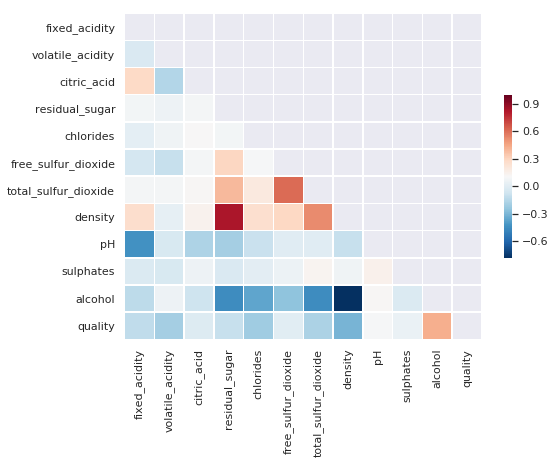

In [9]:
corr = df.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(corr, mask=mask, vmax=1, linewidths=.5, cbar_kws={"shrink": .5}, ax=ax, cmap="RdBu_r");

In [10]:

def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

print("Top Absolute Correlations")
print(get_top_abs_correlations(df[["fixed_acidity", "volatile_acidity", "citric_acid", "residual_sugar", "chlorides", "free_sulfur_dioxide", "total_sulfur_dioxide", "density", "pH", "sulphates", "alcohol", "quality"]], 20))

Top Absolute Correlations
residual_sugar        density                 0.838966
density               alcohol                 0.780138
free_sulfur_dioxide   total_sulfur_dioxide    0.615501
total_sulfur_dioxide  density                 0.529881
residual_sugar        alcohol                 0.450631
total_sulfur_dioxide  alcohol                 0.448892
alcohol               quality                 0.435575
fixed_acidity         pH                      0.425858
residual_sugar        total_sulfur_dioxide    0.401439
chlorides             alcohol                 0.360189
density               quality                 0.307123
residual_sugar        free_sulfur_dioxide     0.299098
free_sulfur_dioxide   density                 0.294210
fixed_acidity         citric_acid             0.289181
                      density                 0.265331
chlorides             density                 0.257211
free_sulfur_dioxide   alcohol                 0.250104
chlorides             quality          

# Outliers

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

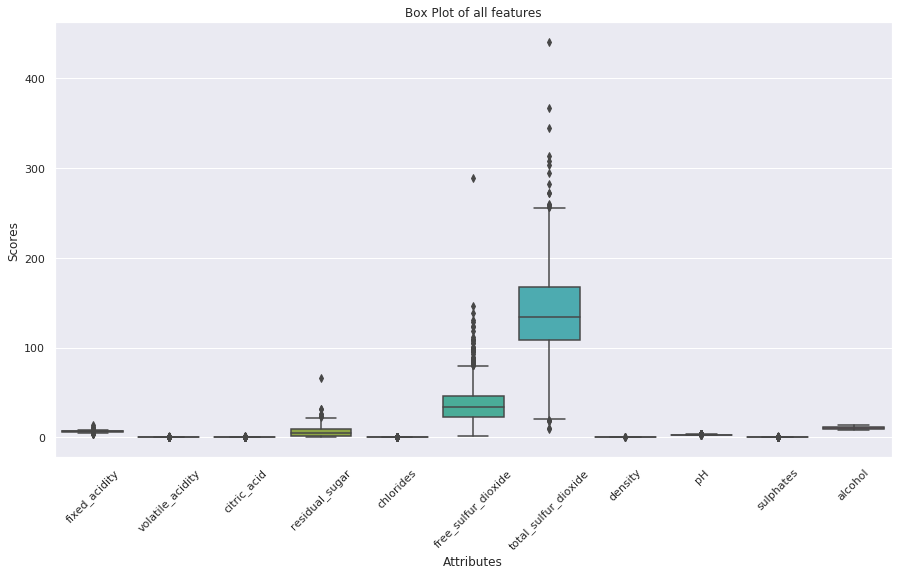

In [11]:
ax=sns.boxplot(data = df[["fixed_acidity", "volatile_acidity", "citric_acid", "residual_sugar", "chlorides", "free_sulfur_dioxide", "total_sulfur_dioxide", "density", "pH", "sulphates", "alcohol"]])
ax.set(xlabel='Attributes', ylabel='Scores', title="Box Plot of all features")
plt.setp(ax.get_xticklabels(), rotation=45)

[Text(0, 0.5, 'Scores'),
 Text(0.5, 0, 'total_sulfur_dioxide'),
 Text(0.5, 1.0, 'Box Plot for total sulfur dioxide')]

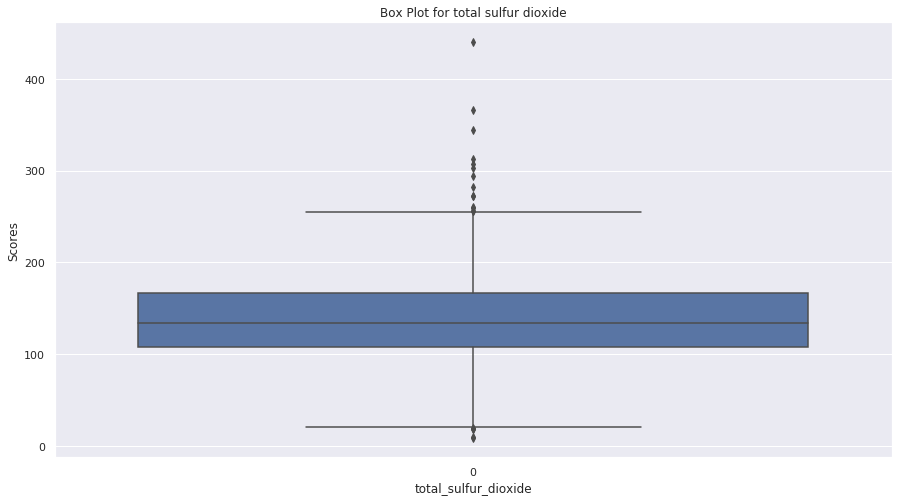

In [12]:
ax = sns.boxplot(data=df['total_sulfur_dioxide'])
ax.set(xlabel='total_sulfur_dioxide', ylabel='Scores', title="Box Plot for total sulfur dioxide")

[Text(0, 0.5, 'Scores'),
 Text(0.5, 0, 'free_sulfur_dioxide'),
 Text(0.5, 1.0, 'Box Plot for free sulfur dioxide')]

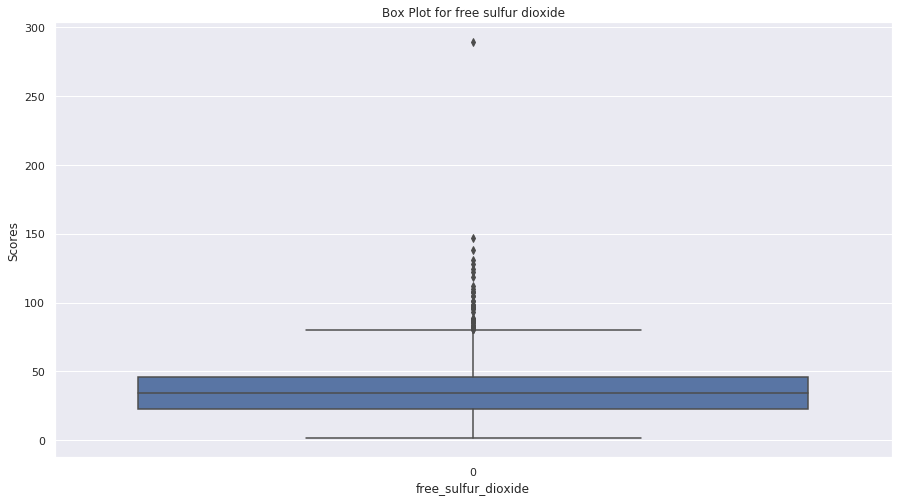

In [13]:
ax = sns.boxplot(data=df['free_sulfur_dioxide'])
ax.set(xlabel='free_sulfur_dioxide', ylabel='Scores', title="Box Plot for free sulfur dioxide")

[Text(0, 0.5, 'Scores'),
 Text(0.5, 0, 'residual_sugar'),
 Text(0.5, 1.0, 'Box Plot for total residual sugar')]

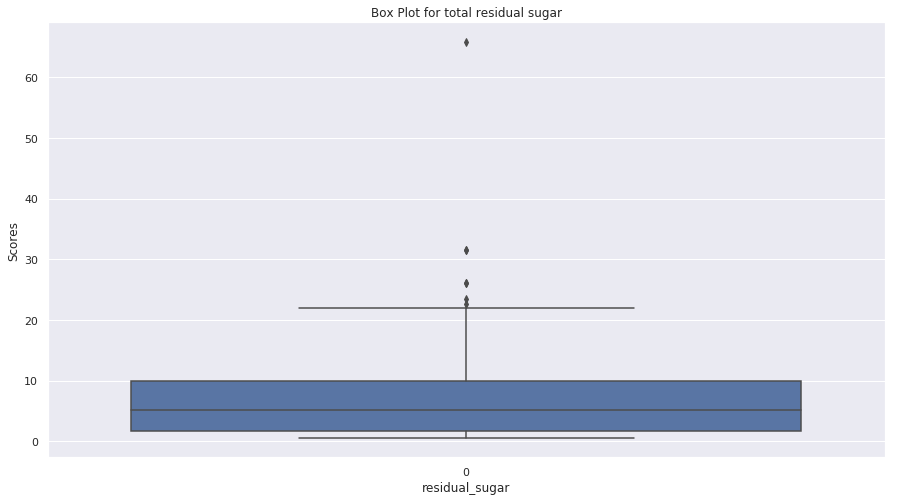

In [14]:
ax = sns.boxplot(data=df['residual_sugar'])
ax.set(xlabel='residual_sugar', ylabel='Scores', title="Box Plot for total residual sugar")

In [15]:
def dropOutliers(feature):
    feat = df[feature]

    q1 = feat.quantile(0.25)
    q3 = feat.quantile(0.75)
    iqr = q3 - q1
    lw = q1 - 1.5 * iqr
    uw = q3 + 1.5 * iqr
    
    outlier_predicate = (df[feature] > uw) | (df[feature] < lw)
    
    print("Lower:", lw)
    print("Upper:", uw)
    print("Total outliers:", df[outlier_predicate].count()[feature])
    
    df.drop(df.index[outlier_predicate], inplace=True) # Drop the rows


dropOutliers('total_sulfur_dioxide')

Lower: 19.5
Upper: 255.5
Total outliers: 19


In [16]:
dropOutliers('residual_sugar')

Lower: -10.600000000000001
Upper: 22.200000000000003
Total outliers: 7


In [17]:
dropOutliers('free_sulfur_dioxide')

Lower: -11.5
Upper: 80.5
Total outliers: 45


In [18]:
df.shape

(4827, 12)

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

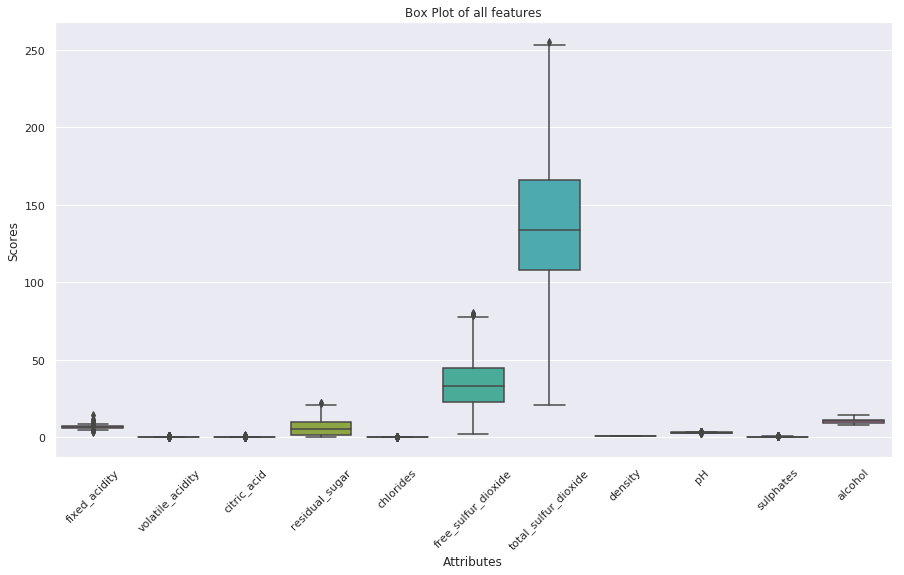

In [ ]:
ax=sns.boxplot(data = df[["fixed_acidity", "volatile_acidity", "citric_acid", "residual_sugar", "chlorides", "free_sulfur_dioxide", "total_sulfur_dioxide", "density", "pH", "sulphates", "alcohol"]])
ax.set(xlabel='Attributes', ylabel='Scores', title="Box Plot of all features")
plt.setp(ax.get_xticklabels(), rotation=45)

# Linear Regression Model

0.2920964111111626
Root mean squared error 0.7397423451673655


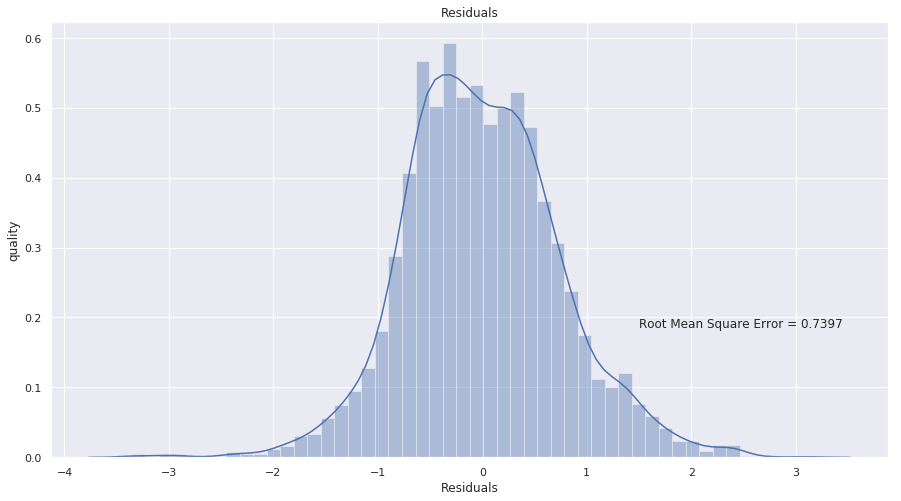

In [ ]:
X = df.drop(['quality'], axis='columns')  # X = features
y = df['quality']                       # y = prediction target

lmreg = LinearRegression()

lmreg.fit(X, y)

yhat = lmreg.predict(X)
lmresid = y - yhat
sns.distplot(lmresid)
plt.title('Residuals')

print(lmreg.score(X, y))

rmse = np.mean((yhat - y) ** 2)**.5

mean = df['quality'].mean()
var = np.sqrt(df['quality'].var())
print("Root mean squared error", rmse)

plt.xlabel('Residuals')
plt.ylabel('quality')
plt.text(1.5, 0.20,"Root Mean Square Error = %.4g" % rmse, ha='left', va='top')

plt.show()


/home/ahernd2/.local/lib/python3.6/site-packages/matplotlib/tight_layout.py:199: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  warnings.warn('Tight layout not applied. '


Text(12.5, 2, 'Root Mean Square Error = 0.7397')

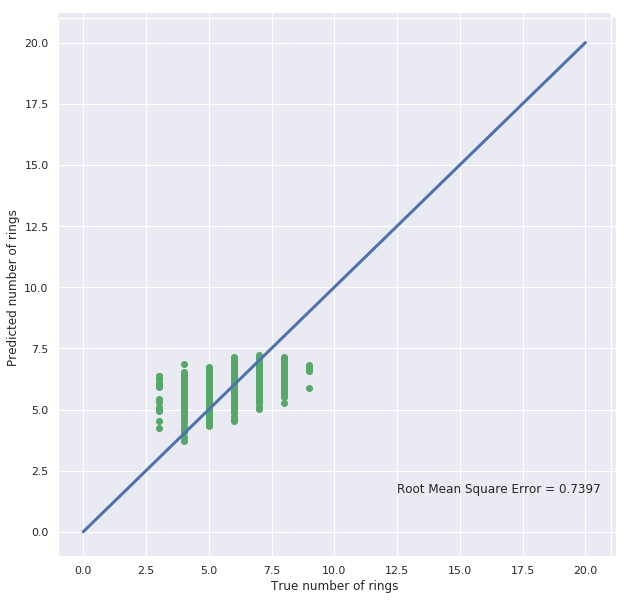

In [ ]:
grid  = sns.JointGrid(y, yhat, space=0, height=10, ratio=100)
ax = grid.plot_joint(plt.scatter, color="g")
plt.plot([0, 20], [0, 20], linewidth=3)

plt.xlabel('True number of rings')
plt.ylabel('Predicted number of rings')
plt.text(12.5, 2,"Root Mean Square Error = %.4g" % rmse, ha='left', va='top')

# Lasso Regression

/home/ahernd2/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


0.27079454079118714
Root mean squared error 0.7397423451673655


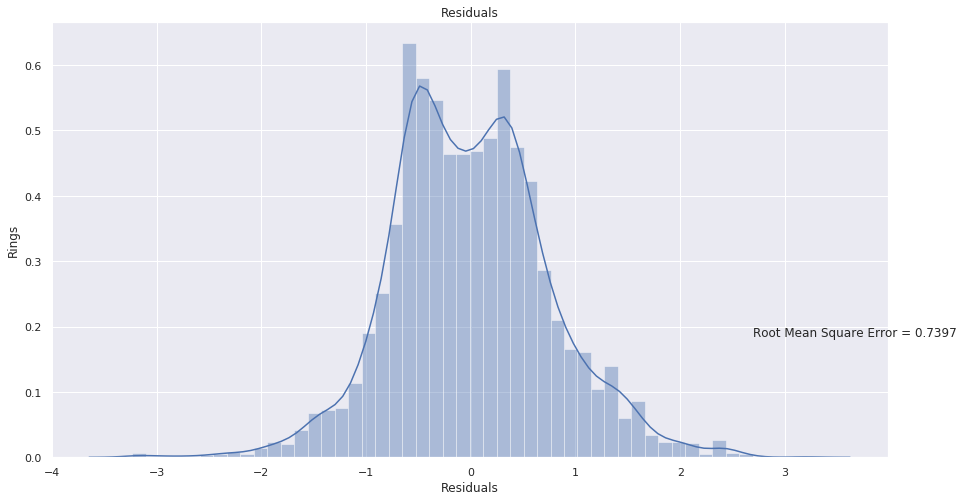

In [ ]:
lass = LassoCV(random_state=0)
lass = lass.fit(X, y)

lassyhat = lass.predict(X)
lmresid = y - lassyhat
sns.distplot(lmresid)
plt.title('Residuals')

print(lass.score(X, y))

rmse = np.mean((yhat - y) ** 2)**.5

mean = df['quality'].mean()
var = np.sqrt(df['quality'].var())
print("Root mean squared error", rmse)

plt.xlabel('Residuals')
plt.ylabel('Rings')
plt.text(2.7, 0.20,"Root Mean Square Error = %.4g" % rmse, ha='left', va='top')

plt.show()

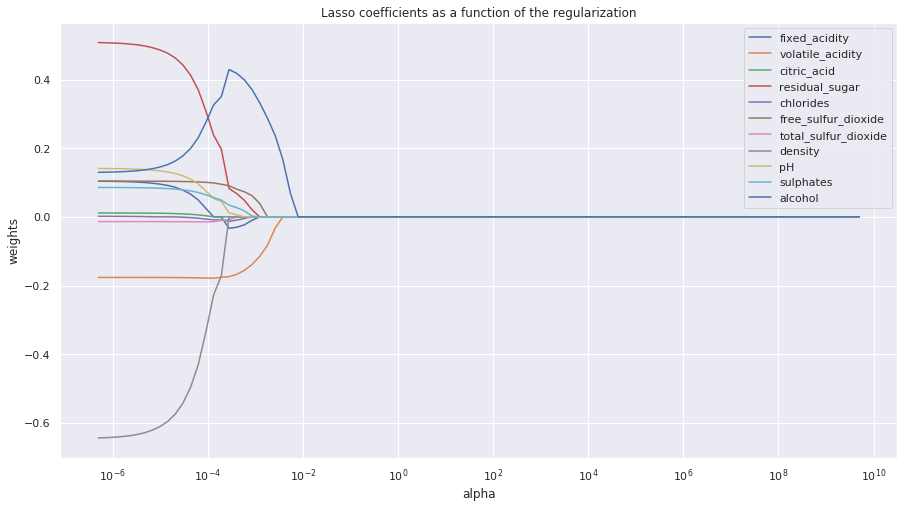

In [ ]:
n_alphas = 200
alphas = 10**np.linspace(10,-6,100)*0.5
X = df.drop(['quality'], axis='columns')  # X = features
y = df['quality']                       # y = prediction target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
lasso = Lasso(alpha=0.1,max_iter = 10000, normalize=True)

coefs = []
for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(scale(X_train), y_train)
    coefs.append(lasso.coef_)

ax = plt.gca()

ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('weights')
plt.legend(X)
plt.title('Lasso coefficients as a function of the regularization')
plt.axis('tight')
plt.show()

In [ ]:
X_train, X_test , y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
ridge2 = Ridge(alpha = 0.005, normalize = True)
ridge2.fit(X_train, y_train)
inner_cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=0)

pipeline = make_pipeline(
    ridge2
)

def svc_param_selection(X, y, nfolds):
    param_grid = {
                    'alpha':np.arange(0, 1, 0.001),
                    'random_state':np.arange(0, 10, 0.5)
                 }
    grid_search = GridSearchCV(ridge2, param_grid, n_jobs=-1, cv=nfolds)
    grid_search.fit(X, y)
    grid_search.best_params_
    return {
            'bestParams': grid_search.best_params_, 
            'bestScore': grid_search.best_score_, 
            'bestEstmator': grid_search.best_estimator_
           }

print(svc_param_selection(X, y, inner_cv))